# 特征匹配 + 单应性查找对象

### 目标

在本章节中，
- 我们将把calib3d模块中的特征匹配和findHomography混合在一起，以在复杂图像中找到已知对象。
 
### 基础

那么我们在上一环节上做了什么？我们使用了queryImage，找到了其中的一些特征点，我们使用了另一个trainImage，也找到了该图像中的特征，并且找到了其中的最佳匹配。简而言之，我们在另一个混乱的图像中找到了对象某些部分的位置。此信息足以在trainImage上准确找到对象。

为此，我们可以使用calib3d模块中的函数，即**cv.findHomography**()。如果我们从两个图像中传递点集，它将找到该对象的透视变换。然后，我们可以使用**cv.perspectiveTransform**()查找对象。找到转换至少需要四个正确的点。

我们已经看到，匹配时可能会出现一些可能影响结果的错误。为了解决这个问题，算法使用`RANSAC`或`LEAST_MEDIAN`（可以由标志决定）。因此，提供正确估计的良好匹配称为“内部点”，其余的称为“外部点”。**cv.findHomography**()返回指定内部和外部点的掩码。

让我们开始吧！！！

### 代码

首先，像往常一样，让我们​​在图像中找到SIFT功能并应用比例测试以找到最佳匹配。

In [1]:
import numpy as np
import cv2 as cv
from matplotlib import pyplot as plt

MIN_MATCH_COUNT = 10

img1 = cv.imread('data/box.png',0)          # 索引图像
img2 = cv.imread('data/box_in_scene.png',0) # 训练图像

# 初始化SIFT检测器
sift = cv.xfeatures2d.SIFT_create()

# 用SIFT找到关键点和描述符
kp1, des1 = sift.detectAndCompute(img1,None)
kp2, des2 = sift.detectAndCompute(img2,None)

FLANN_INDEX_KDTREE = 1

index_params = dict(algorithm = FLANN_INDEX_KDTREE, trees = 5)
search_params = dict(checks = 50)

flann = cv.FlannBasedMatcher(index_params, search_params)
matches = flann.knnMatch(des1,des2,k=2)

# 根据Lowe的比率测试存储所有符合条件的匹配项。
good = []

for m,n in matches:
    if m.distance < 0.7*n.distance:
        good.append(m)

现在我们设置一个条件，即至少有10个匹配项（由`MIN_MATCH_COUNT`定义）可以找到对象。否则，只需显示一条消息，说明没有足够的匹配项。

如果找到足够的匹配项，我们将在两个图像中提取匹配的关键点的位置。他们被传递以寻找预期的转变。一旦获得了这个3x3转换矩阵，就可以使用它将索引图像的角转换为训练图像中的相应点。然后我们画出来。

In [2]:
if len(good)>MIN_MATCH_COUNT:
    src_pts = np.float32([ kp1[m.queryIdx].pt for m in good ]).reshape(-1,1,2)
    dst_pts = np.float32([ kp2[m.trainIdx].pt for m in good ]).reshape(-1,1,2)

    M, mask = cv.findHomography(src_pts, dst_pts, cv.RANSAC,5.0)
    matchesMask = mask.ravel().tolist()

    h,w = img1.shape

    pts = np.float32([ [0,0],[0,h-1],[w-1,h-1],[w-1,0] ]).reshape(-1,1,2)
    dst = cv.perspectiveTransform(pts,M)
    
    img2 = cv.polylines(img2,[np.int32(dst)],True,255,3, cv.LINE_AA)
else:
    print( "Not enough matches are found - {}/{}".format(len(good), MIN_MATCH_COUNT) )
    matchesMask = None

最后，我们绘制内部线（如果成功找到对象）或匹配关键点（如果失败）。

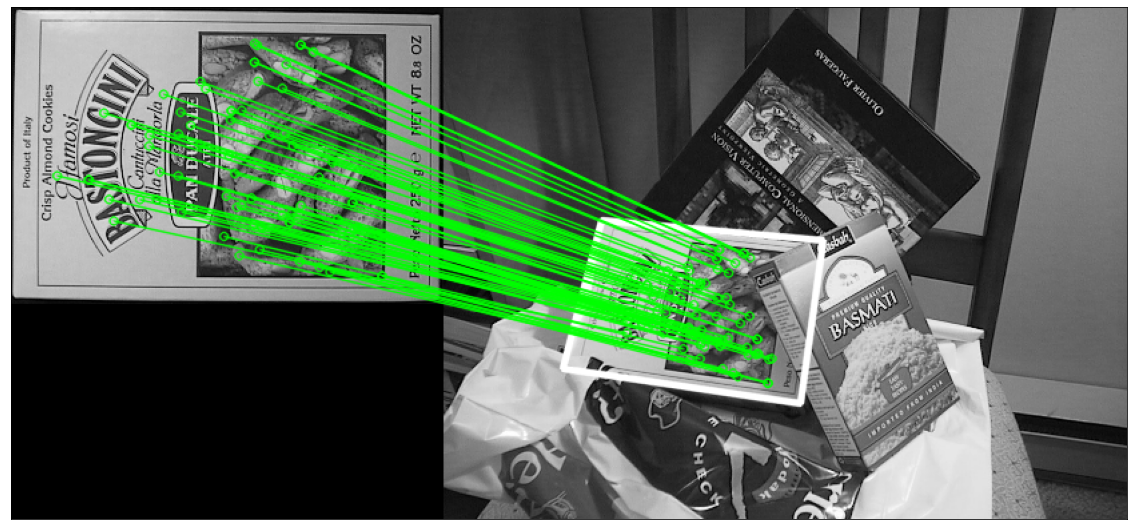

In [3]:
draw_params = dict(matchColor = (0,255,0), # 用绿色绘制匹配
                   singlePointColor = None,
                   matchesMask = matchesMask, # 只绘制内部点
                   flags = 2)

img3 = cv.drawMatches(img1,kp1,img2,kp2,good,None,**draw_params)

plt.figure(figsize=(20,10))
plt.imshow(cv.cvtColor(img3,cv.COLOR_BGR2RGB))
plt.xticks([]), plt.yticks([])
plt.show()

对象在混乱的图像中标记为白色：

### 附加资源

### 练习